# Imports

In [1]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2024-07-08 13:14:18.014158: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-07-08 13:14:20.186749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 13:14:21.784827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18300 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6


In [2]:
from orbit_generation.visualize import visualize_static_orbits, plot_latent_space_2d, export_dynamic_orbits_html, plot_combined_latent_space_2d, plot_latent_space_with_feature_distributions
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.experiment import get_experiment_parameters, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, find_non_matching_elements

In [3]:
import numpy as np
import tsgm
import os
import pandas as pd

2024-07-08 13:14:25.651082: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-08 13:14:25.654630: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x6db4110


# Load

In [4]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'
experiment_folder = r'../experiments/experiment_1'
experiment_id = int(experiment_folder[-1])

In [5]:
images_folder = os.path.join(experiment_folder, 'images')
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
initial_conditions_file = os.path.join(experiment_folder, 'corrected_initial_conditions.npy')
generated_data_file = os.path.join(experiment_folder, 'propagated_corrected_ICs.npy')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')

In [6]:
params=get_experiment_parameters(experiments_folder=experiments_folder, experiment_id=experiment_id)

data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 300)

In [7]:
transposed_orbits = np.transpose(data, (0, 2, 1))

scaler = tsgm.utils.TSFeatureWiseScaler()   
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(45211, 300, 7)

In [8]:
if params['model_name']=='vae_conv5':
    encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
    decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
    encoder = tf.keras.models.load_model(encoder_save_path)
    decoder = tf.keras.models.load_model(decoder_save_path)
    model = tsgm.models.cvae.BetaVAE(encoder, decoder)
else:
    model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
    model = tf.keras.models.load_model(model_save_path)

# Latent Space

In [9]:
latent_mean, latent_deviation, latent_epsilon = model.encoder(scaled_data)
latent_representations = latent_mean.numpy()
combined_latent_representation = np.concatenate((latent_mean, latent_deviation), axis=1)

np.save(latent_representations_path, combined_latent_representation)

combined_latent_representation.shape

2024-07-08 13:15:36.724594: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-07-08 13:15:39.750142: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-08 13:15:39.750179: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-07-08 13:15:40.004853: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were avai

(45211, 4)

In [10]:
id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
classes=get_orbit_classes(id_classes)

features=orbit_df[['jacobi', 'period', 'stability']].to_numpy()
feature_names=['jacobi', 'period', 'stability']

## Visualize

Saved plot to ../experiments/experiment_1/images/exp1_latent_space_label


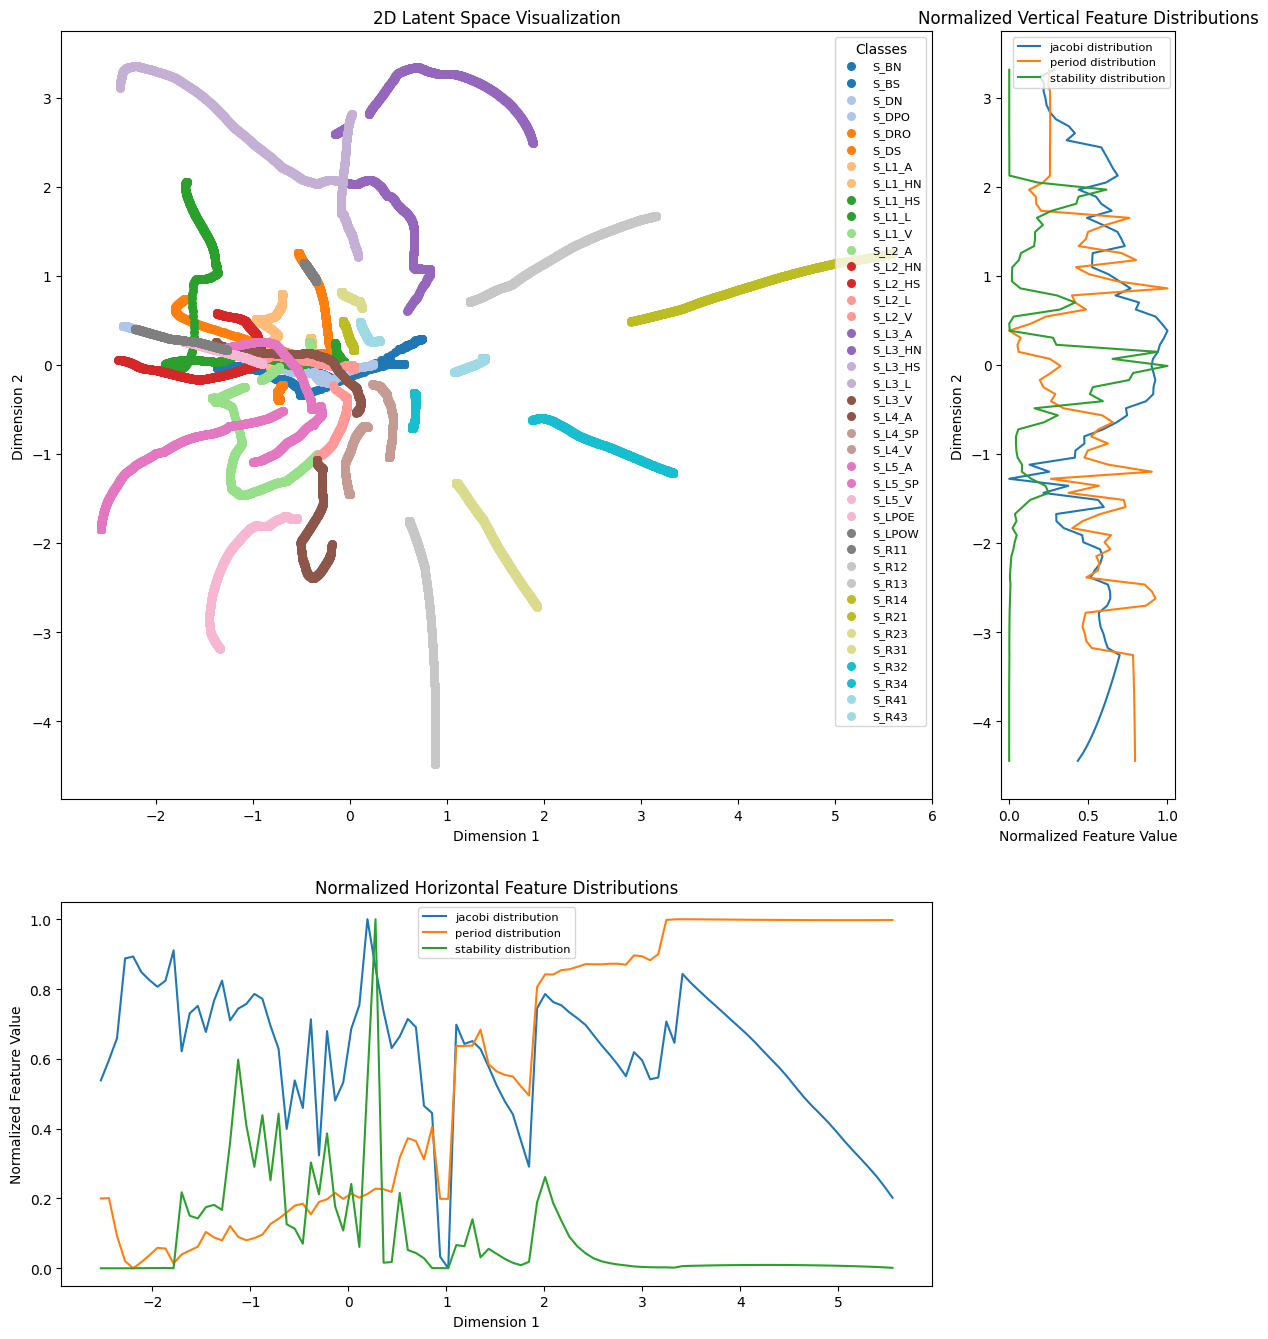

Saved plot to ../experiments/experiment_1/images/exp1_latent_space_type


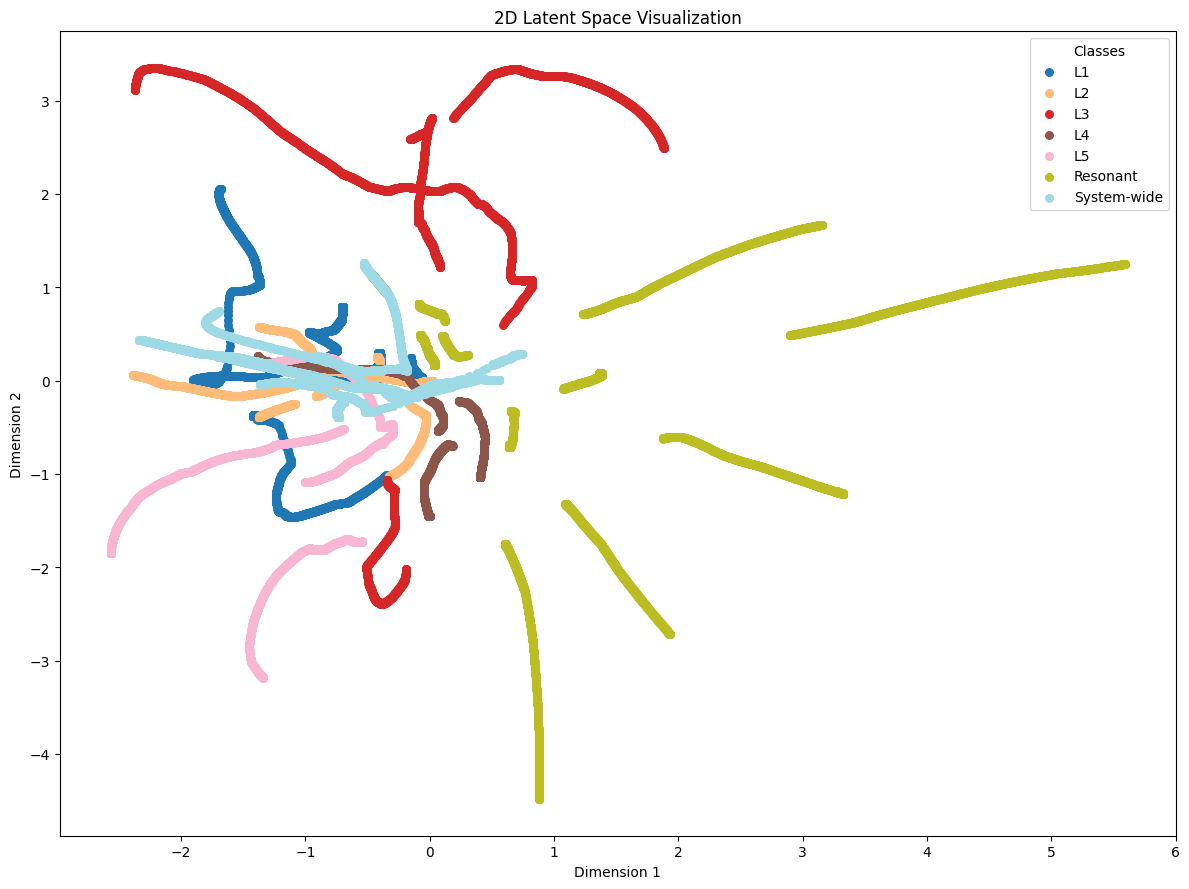

Saved plot to ../experiments/experiment_1/images/exp1_latent_space_subtype


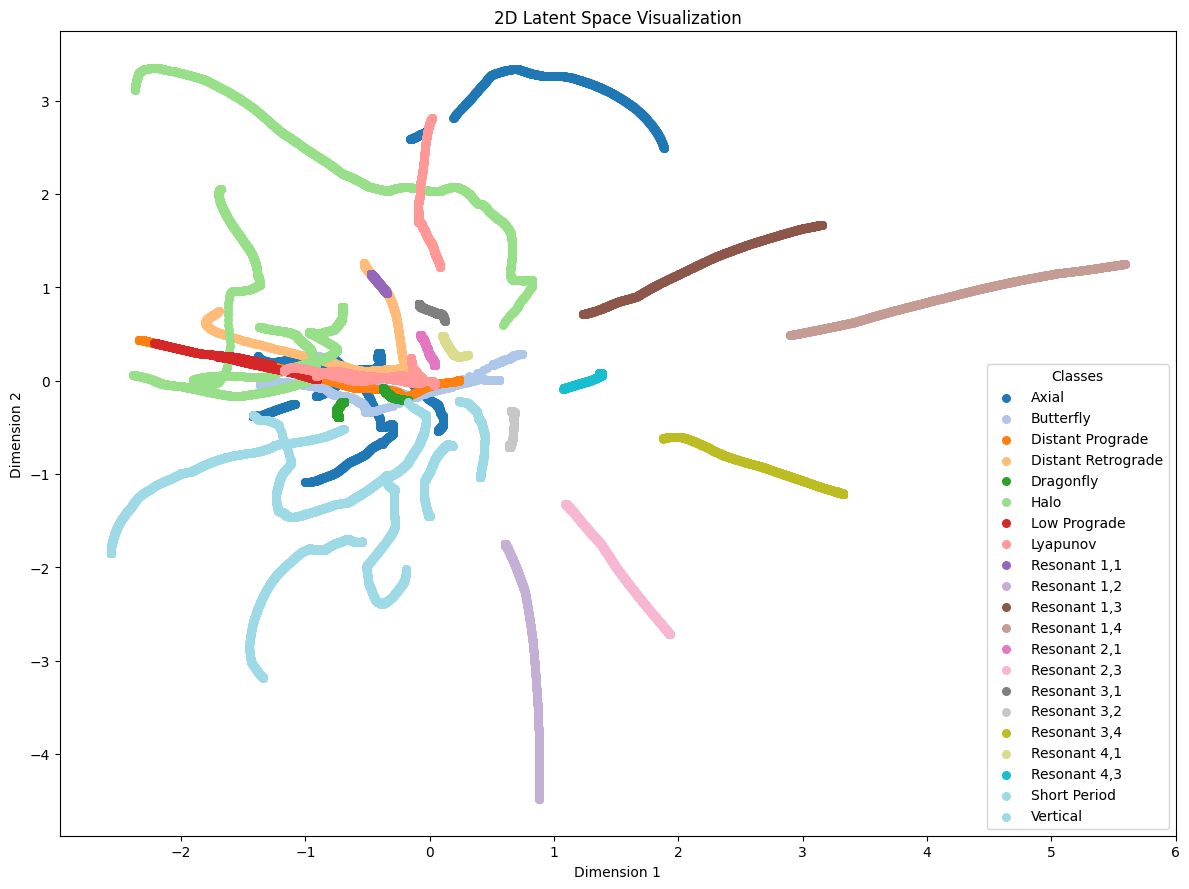

Saved plot to ../experiments/experiment_1/images/exp1_latent_space_direction


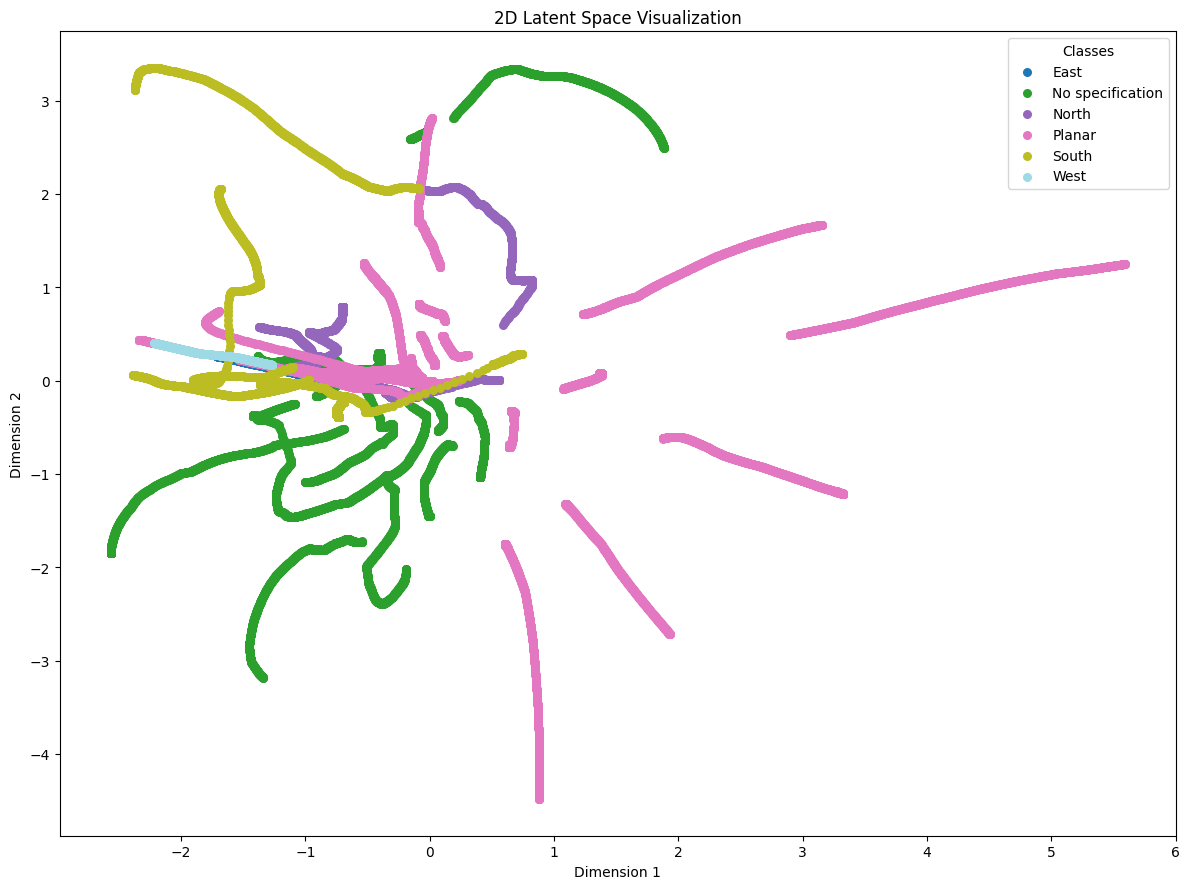

In [11]:
if latent_representations.shape[1]==2:
    plot_latent_space_with_feature_distributions(latent_representations, np.array(classes[0]), save_path=latent_space_path +'_label',
                                                 many_classes=False, features=features, feature_names=feature_names, show_legend=True, legend_fontsize=8.25)
    plot_latent_space_2d(latent_representations, np.array(classes[1]), save_path=latent_space_path +'_type')
    plot_latent_space_2d(latent_representations, np.array(classes[2]), save_path=latent_space_path +'_subtype')
    plot_latent_space_2d(latent_representations, np.array(classes[3]), save_path=latent_space_path +'_direction')

## Clustering

In [12]:
cluster_metrics = evaluate_clustering_multiple_labels(latent_representations, classes, label_names=['label','type','subtype','direction'], clustering_method='gmm')
add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

Metrics added to experiment with ID 1 in ../experiments/experiments.json.


# Convergence

In [ ]:
initial_conditions = np.load(initial_conditions_file)
columns= ['id','old_period', 'new_period', 'iterations_convergence','error','pos_x0','pos_y0','pos_z0','vel_x0','vel_y0','vel_z0']
df = pd.DataFrame(initial_conditions, columns=columns)
generated_data = np.load(generated_data_file)
generated_data.shape

,id,old_period,new_period,iterations_convergence,error,pos_x0,pos_y0,pos_z0,vel_x0,vel_y0,vel_z0
0,5.0,6.222030,6.192932,9.0,6.301578e-12,0.874645,-0.111746,-2.606991e-01,-0.183580,-0.364638,-8.920535e-01
1,7.0,6.791755,6.334867,20.0,4.204361e-14,-6.770056,-23.728922,-1.030387e-20,-23.535336,6.714824,3.379070e-25
2,11.0,6.336819,6.546722,7.0,4.462795e-10,0.561438,-1.094286,-3.753770e-15,-0.373137,-0.229283,7.069713e-14
3,12.0,10.498634,12.298088,12.0,4.171158e-12,0.943796,-1.140043,1.203071e-13,-0.577731,-0.291908,-5.175010e-15
4,13.0,6.416141,4.694308,9.0,4.954805e-12,1.277904,1.616904,2.503308e-13,2.164505,-1.709546,1.794688e-13


In [ ]:
if generated_data.shape[2] == 7:
    inverted2_generation = generated_data[:,:,1:]
    inverted2_generation.shape
else:
    inverted2_generation = generated_data

display_generation = np.transpose(inverted2_generation, (0, 2, 1))
display_generation.shape

(51, 6, 300)

## Visualize

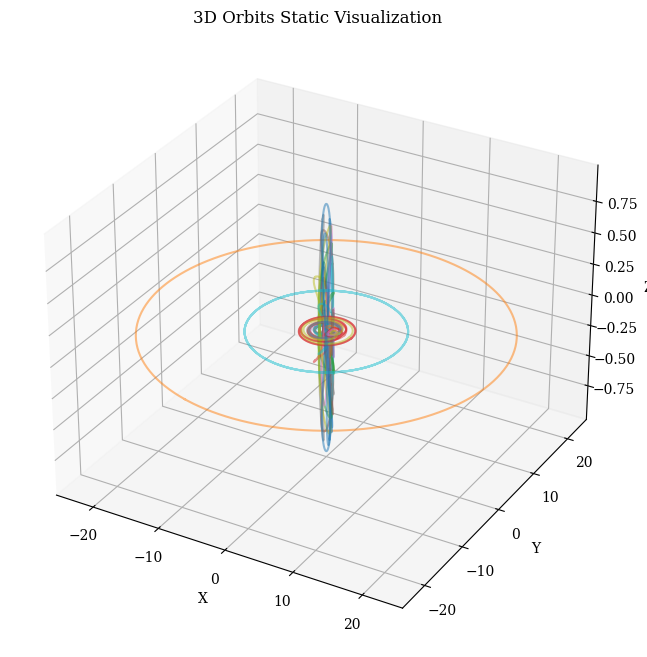

In [ ]:
visualize_static_orbits(display_generation, show_legend=False, save_path=converged_orbits_path)

## Metrics

In [ ]:
generated_scaled_data = scaler.transform(generated_data)
generation_latent_mean, generation_latent_deviation, generation_latent_epsilon = model.encoder(generated_scaled_data)
generation_latent_representations = latent_mean.numpy()
generation_combined_latent_representation = np.concatenate((generation_latent_mean, generation_latent_deviation), axis=1)

generation_combined_latent_representation.shape

(51, 4)

In [ ]:
# Call the function
non_matching_elements = find_non_matching_elements(combined_latent_representation, generation_combined_latent_representation)

In [ ]:
convergence_metrics = {'percentage_convergence':len(non_matching_elements)/100 , 'average_iterations_convergence':df['iterations_convergence'].mean()}
add_experiment_metrics(experiments_folder, params=params, metrics=convergence_metrics)

## Latent Space

1415/1415 [==============================] - 8s 5ms/step


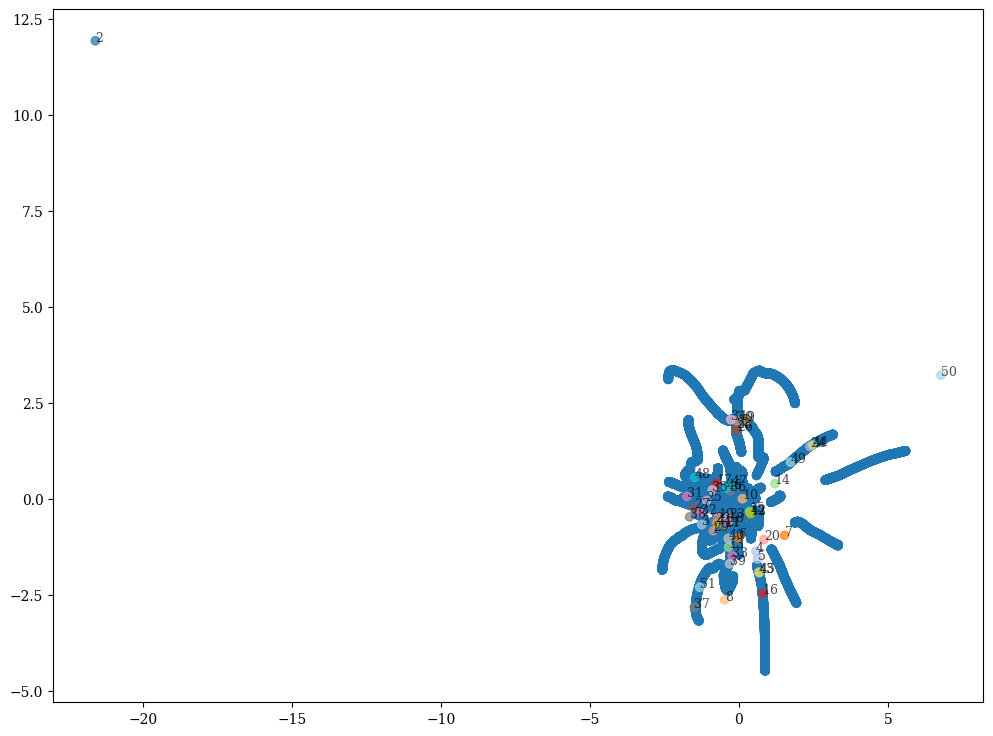

In [ ]:
plot_combined_latent_space_2d(
    real_data=scaled_data, 
    synthetic_data=generated_scaled_data, 
    encoder=encoder, 
    synthetic_labels=list(range(1, 52)),
    annotation_mode='numbers',
    save_path=combined_latent_space_path
)